In [151]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings(action='ignore')

In [152]:
labels_dataframe=pd.read_csv('../input/paddy-disease-classification/train.csv')
sub_df=pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')

In [153]:
labels_dataframe

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [154]:
sub_df

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [155]:
diseases_types=sorted(list(set(labels_dataframe['label'])))
n_classes=len(diseases_types)
print(n_classes)
print(diseases_types)

10
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [156]:
train_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=diseases_types,
                                                        color_mode='rgb',
                                                        image_size=(680,480),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        seed=42)

val_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=diseases_types,   
                                                        color_mode='rgb',
                                                        image_size=(680,480),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=42)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [157]:
train_data

<BatchDataset shapes: ((None, 680, 480, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [158]:
val_data

<BatchDataset shapes: ((None, 680, 480, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [159]:
from tensorflow.keras import models,layers

In [160]:
resnet_model=models.Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,input_shape=(680,480,3),pooling='avg',classes=10,weights='imagenet')
    
for layer in pretrained_model.layers:
    layer.trainable=False
    
    
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512,activation='relu'))
resnet_model.add(layers.Dense(99,activation='relu'))
resnet_model.add(layers.Dense(10,activation='softmax'))

In [161]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 99)                50787     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1000      
Total params: 24,688,587
Trainable params: 1,100,875
Non-trainable params: 23,587,712
_________________________________________________________________


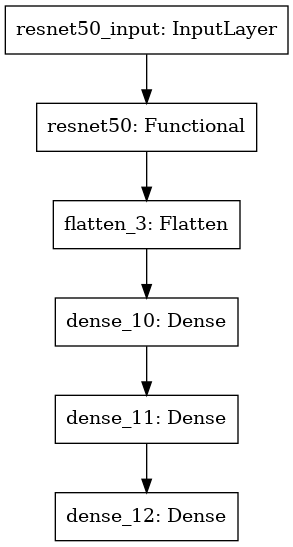

In [162]:
tf.keras.utils.plot_model(resnet_model)

In [180]:
resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
resnet_model.fit(train_data,validation_data=val_data,epochs=15)

Epoch 1/15
261/261 [==============================] - 212s 529ms/step - loss: 0.0659 - accuracy: 0.9760 - val_loss: 0.3762 - val_accuracy: 0.9005
Epoch 2/15
261/261 [==============================] - 138s 522ms/step - loss: 0.0357 - accuracy: 0.9874 - val_loss: 0.2672 - val_accuracy: 0.9361
Epoch 3/15
261/261 [==============================] - 138s 525ms/step - loss: 0.0848 - accuracy: 0.9718 - val_loss: 0.2804 - val_accuracy: 0.9303
Epoch 4/15
261/261 [==============================] - 139s 528ms/step - loss: 0.0387 - accuracy: 0.9877 - val_loss: 0.3293 - val_accuracy: 0.9217
Epoch 5/15
261/261 [==============================] - 139s 526ms/step - loss: 0.0482 - accuracy: 0.9841 - val_loss: 0.5097 - val_accuracy: 0.8871
Epoch 6/15
261/261 [==============================] - 139s 529ms/step - loss: 0.0657 - accuracy: 0.9777 - val_loss: 0.2928 - val_accuracy: 0.9380
Epoch 7/15
261/261 [==============================] - 140s 530ms/step - loss: 0.0787 - accuracy: 0.9742 - val_loss: 0.3053 -

In [168]:
test_data=tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/test_images/",
                                                        labels=None,
                                                        label_mode=None,
                                                        color_mode='rgb',
                                                        image_size=(680,480),
                                                        shuffle=False)

Found 3469 files belonging to 1 classes.


In [171]:
predict=tf.argmax(resnet_model.predict(test_data),axis=-1)
predict

<tf.Tensor: shape=(3469,), dtype=int64, numpy=array([7, 8, 3, ..., 8, 1, 5])>

In [172]:
predictions=[]
for i in predict:
    predictions.append(diseases_types[i])

In [173]:
predictions[:10]

['hispa',
 'normal',
 'blast',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

In [176]:
sub_df=sub_df.drop(columns='label',axis=1)
sub_df

,image_id
0,200001.jpg
1,200002.jpg
2,200003.jpg
3,200004.jpg
4,200005.jpg
...,...
3464,203465.jpg
3465,203466.jpg
3466,203467.jpg
3467,203468.jpg


In [178]:
submission=pd.DataFrame({'image_id':sub_df['image_id'],'label':predictions})
submission

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [179]:
submission.to_csv('paddy_docto2.csv',index=None)